In [1]:
# magic to reload modules when they change
%load_ext autoreload
%autoreload 2

# Initial Unoptimized code

In [ ]:
import os
import copy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from tab_transformer_copy import TabTransformer_edit
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from tab_transformer_pytorch import TabTransformer, FTTransformer
from helper_analysis import normalize_data, load_and_combine_data, format_array, load_and_normalize_data_tensor, denormalize_data, min_max_scale

folder_path = "your_output_folder_path"  # Replace with your folder path with your data
epochs_dl = 2500 # For deep learning models
epochs_dl_tab = 20 # For TabNet model
epochs_ml = 200 # For machine learning models
max_files = 5  # Maximum number of files to process
seed = 42
scaling_type = "minmax"  # "minmax" or any other for z-score
scheduler = 0  # 1 for step, 2 for plateau, 3 for cosine
patience = 30

# Define the ratio for the train-test split
train_ratio = 0.9

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Define your L1 regularization strength
l1_lambda = 0.0001
l2_lambda = 0.0001

In [2]:
# Load and normalize the data
E_tensor, E_return, E_return2 = load_and_normalize_data_tensor(folder_path, "E_combo_output", max_files=max_files)
A_tensor, _, _ = load_and_normalize_data_tensor(folder_path, "A_combo_output", max_files=max_files)
J_tensor, _, _ = load_and_normalize_data_tensor(folder_path, "J_combo_output", max_files=max_files)
h_tensor, _, _ = load_and_normalize_data_tensor(folder_path, "h_combo_output", max_files=max_files)
X_tensor, _, _ = load_and_normalize_data_tensor(folder_path, "X_combo_output", max_files=max_files)
w_tensor, _, _ = load_and_normalize_data_tensor(folder_path, "w_combo_output", max_files=max_files)
T_tensor, _, _ = load_and_normalize_data_tensor(folder_path, "T_combo_output", max_files=max_files)

# After loading the data. Make a new data tensor of size (n_samples, n_features) taking A_tensor as reference
# Starting from the 2nd index and moving by 3 beta (the angle) will be 0 and the rest will be 90 degrees (pi/2)


E_tensor.shape, A_tensor.shape, J_tensor.shape, h_tensor.shape, X_tensor.shape, w_tensor.shape

(torch.Size([81922, 15]),
 torch.Size([81922, 15]),
 torch.Size([81922, 15]),
 torch.Size([81922, 15]),
 torch.Size([81922, 45]),
 torch.Size([81922, 45]))

In [ ]:
col_idx = [0,1,3,4,6,7,9,10,12,13]
beta_tensor = torch.zeros(A_tensor.shape)
type_tensor = torch.zeros(A_tensor.shape)
type_tensor[:, col_idx] = 1
beta_tensor[:, col_idx] = np.pi/2
# beta_tensor, _, _ = normalize_data(beta_tensor)
# Reshape type_tensor to have a shape of (81922, 1)
type_tensor = type_tensor[:, :1]

# In case of missing values for non-damaged data
# Create A_original_tensor of size (n_samples, n_features) with values [0.105, 0.16] with 0.16 for col_idx and 0.105 for the rest
# A_original_tensor = torch.zeros(A_tensor.shape)
# A_original_tensor[:, col_idx] = 0.16

# Make an E tensor with the same shape as E_tensor but all the values are 21*10**7
# E_original_tensor = torch.zeros(E_tensor.shape)
# E_original_tensor[:, :] = 21*10**7
# E_original_tensor, _, _ = normalize_data(E_original_tensor)


c:\Users\kaido\anaconda3\envs\ds\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0, Loss: 0.8042696118354797, Val Loss: 0.6857430338859558
Loss amplifier: 0.0
Epoch 10, Loss: 0.143502876162529, Val Loss: 0.1222248524427414
Loss amplifier: 0.0
Epoch 20, Loss: 0.10190340131521225, Val Loss: 0.10216639935970306
Loss amplifier: 0.0
Epoch 30, Loss: 0.09330277144908905, Val Loss: 0.09034019708633423
Loss amplifier: 0.0
Epoch 40, Loss: 0.08600609004497528, Val Loss: 0.08544498682022095
Loss amplifier: 0.0
Epoch 50, Loss: 0.0816267728805542, Val Loss: 0.0829775258898735
Loss amplifier: 0.0
Epoch 60, Loss: 0.07855284959077835, Val Loss: 0.0789579302072525
Loss amplifier: 0.0
Epoch 70, Loss: 0.07539109885692596, Val Loss: 0.0761089026927948
Loss amplifier: 0.0
Epoch 80, Loss: 0.07207562774419785, Val Loss: 0.07402638345956802
Loss amplifier: 0.0
Epoch 90, Loss: 0.06899531185626984, Val Loss: 0.07065395265817642
Loss amplifier: 0.0
[[ 22599472.  27885344.  10888944. ... -18686160.  32637440.  13456624.]
 [ 44503136.  -7371472.  18545680. ...  -7757824.  48815968.  10265

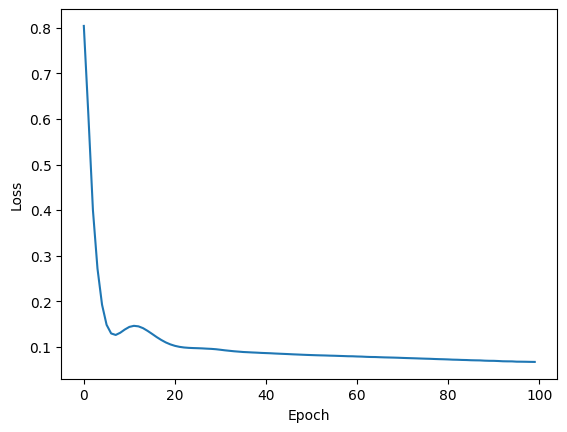

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = TabTransformer_edit(
    categories=(),
    num_continuous=150,               # continuous features
    dim=150,                          # dimension, paper set at 32
    dim_head=16,                      # dimension of each head, paper set at 16
    dim_out=15,                      # 15 due to the shape of E_data
    depth=3,                         # depth, paper recommended 6 (9 worked better by .02%)
    heads=15,                         # heads, paper recommends 8
    attn_dropout=0.6,                # post-attention dropout
    ff_dropout=0.6,                  # feed forward dropout
    mlp_hidden_mults=(4,2),         # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act=nn.ReLU6(),               # activation for final mlp, defaults to relu, but could be anything else (selu, ELU, PReLU, Tanh, Sigmoid)
    mlp_dropout=0.05,
)



# Split X_data and w_data into three separate sets of features
X1_tensor = X_tensor[:, :15].clone().detach()
X2_tensor = X_tensor[:, 15:30].clone().detach()
X3_tensor = X_tensor[:, 30:].clone().detach()
w1_tensor = w_tensor[:, :15].clone().detach()
w2_tensor = w_tensor[:, 15:30].clone().detach()
w3_tensor = w_tensor[:, 30:].clone().detach()

# Concatenate the tensors along the second dimension (features) WITHOUT CATEGORY
x_cont = torch.cat((A_tensor, J_tensor, h_tensor, beta_tensor, w1_tensor, X1_tensor, w2_tensor, X2_tensor, w3_tensor, X3_tensor), dim=1)
x_categ = torch.empty((x_cont.shape[0], 0))

# Split the data into a training set and a test set and get the indices
x_cont_train, x_cont_test, E_train, E_test, train_indices, test_indices = train_test_split(
    x_cont, E_tensor, range(E_tensor.shape[0]), train_size=train_ratio, random_state=seed
)

# Define a loss function and an optimizer
loss_fn = nn.MSELoss()
# loss_fn = nn.SmoothL1Loss()
# loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

# Define a scheduler
if scheduler == 1:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Move the model to the device
model = model.to(device)

# Move the data to the device
x_categ = x_categ.to(device) # This is the only tensor with categorical data
x_cont_train = x_cont_train.to(device)
x_cont_test = x_cont_test.to(device)
E_train = E_train.to(device)
E_test = E_test.to(device)

# For plotting
loss_values = []
best_model = None
best_val_loss = float('inf')
loss_amplifier = .000
epochs_since_improvement = 0
past_losses = []

for epoch in range(epochs_dl):  # Number of epochs
    # Forward pass
    pred_train = model(x_categ[:x_cont_train.shape[0]], x_cont_train)
    loss = loss_fn(pred_train, E_train)

    optimizer.zero_grad()
    (loss/2 + loss/2 * loss_amplifier).backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        pred_val = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
        val_loss = loss_fn(pred_val, E_test)

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Amplify loss function based on validation loss trend
    if epochs_since_improvement >= 10:
        # If validation loss hasn't improved in 5 epochs, reward the model by decreasing the loss amplifier
        loss_amplifier *= 0.99
        epochs_since_improvement = 0  # Reset the counter
    else:
        if epochs_since_improvement >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            break

    # Add additional punishment if the past 10 losses are relatively the same
    past_losses.append(val_loss.item())
    if len(past_losses) > 10:
        past_losses.pop(0)  # remove the oldest loss
        if np.std(past_losses) < 0.0007:  # if the standard deviation of the past 10 losses is small
            loss_amplifier *= 2  # increase the loss amplifier
            past_losses = past_losses[1:]  # Give it a grace period by removing the oldest losses

    # Update the scheduler
    if scheduler:
        scheduler.step(val_loss)

    # If the validation loss is the best we've seen so far, save the model state
    if val_loss <= best_val_loss:
        best_model = copy.deepcopy(model.state_dict())

    model.train()

    # Store the loss value
    loss_values.append(loss.item())

    # Print loss for every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')
        print(f'Loss amplifier: {loss_amplifier}')

# Load the best model state
model.load_state_dict(best_model)

# Test the model
model.eval()
with torch.no_grad():
    pred_test = model(x_categ[:x_cont_test.shape[0]], x_cont_test)

# Move the predictions back to the CPU for further processing
pred_test = pred_test.to("cpu")
E_test = E_test.to("cpu")

# Denormalize the E_tensor
E_test_denorm = denormalize_data(E_test, E_return, E_return2, scaling_type)
E_test_denorm_np = E_test_denorm.numpy()
# Denormalize the predictions
pred_test_denorm = denormalize_data(pred_test, E_return, E_return2, scaling_type)
pred_test_denorm_np = pred_test_denorm.numpy()

# MAPE
mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
# MdAPE
mdape = np.median(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100

# Calculate the difference
difference = E_test_denorm_np - pred_test_denorm_np


print(difference)

print(pred_test, len(pred_test))
print(pred_test_denorm, len(pred_test_denorm))

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# All old results are based on 6 files
print("Difference:\n" + format_array(difference[100], 4))
print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[100], 4))
print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[100], 4))
print(f"\n\nMAPE: {mape.item():.4f}%")
print(f'MdAPE: {mdape}%')

Difference:
[23992736.0000, -12262768.0000, 1265728.0000, -877872.0000, 1215968.0000, 1284640.0000, 51806944.0000, -34119520.0000, 1314064.0000, 9868848.0000,
 -22643808.0000, 1538752.0000, 37335288.0000, -41384912.0000, 1502416.0000]

E_test_denorm:
[210000000.0000, 105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 105000000.0000, 210000000.0000, 210000000.0000,
 157500000.0000, 210000000.0000, 157500000.0000, 52500000.0000, 210000000.0000]

Pred_test_denorm:
[186007264.0000, 117262768.0000, 208734272.0000, 210877872.0000, 208784032.0000, 208715360.0000, 158193056.0000, 139119520.0000, 208685936.0000, 200131152.0000,
 180143808.0000, 208461248.0000, 120164712.0000, 93884912.0000, 208497584.0000]


MAPE: 10.4486%
MdAPE: 4.031451418995857%


Epoch 0, Loss: 0.00583114055916667, Val Loss: 0.22986441850662231
Loss amplifier: 0.001
Epoch 10, Loss: 0.04759063199162483, Val Loss: 0.056401368230581284
Loss amplifier: 0.001
Epoch 20, Loss: 0.03490660712122917, Val Loss: 0.049069005995988846
Loss amplifier: 0.001
Epoch 30, Loss: 0.026929644867777824, Val Loss: 0.041806843131780624
Loss amplifier: 0.001
Epoch 40, Loss: 0.02766173705458641, Val Loss: 0.036893486976623535
Loss amplifier: 0.001
Epoch 50, Loss: 0.0216047465801239, Val Loss: 0.03311355784535408
Loss amplifier: 0.001
Epoch 60, Loss: 0.01955840177834034, Val Loss: 0.030831433832645416
Loss amplifier: 0.001
Epoch 70, Loss: 0.018380824476480484, Val Loss: 0.025354374200105667
Loss amplifier: 0.000995
Epoch 80, Loss: 0.014692837372422218, Val Loss: 0.026153402402997017
Loss amplifier: 0.000995
Epoch 90, Loss: 0.013891144655644894, Val Loss: 0.0255893524736166
Loss amplifier: 0.000990025
Epoch 100, Loss: 0.014348939061164856, Val Loss: 0.03155336156487465
Loss amplifier: 0.000

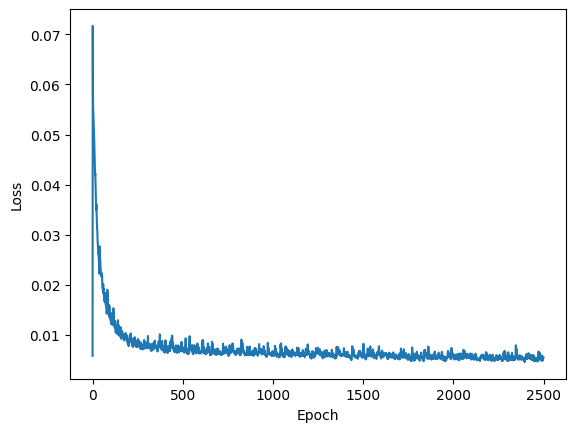

In [ ]:
# Create a new model
new_model = TabTransformer_edit(
    categories=(),
    num_continuous=150,               # continuous features
    dim=150,                          # dimension, paper set at 32
    dim_out=15,                      # 15 due to the shape of E_data
    depth=3,                         # depth, paper recommended 6 (9 worked better by .02%)
    heads=15,                         # heads, paper recommends 8
    attn_dropout=0.1,                # post-attention dropout
    ff_dropout=0.1,                  # feed forward dropout
    mlp_hidden_mults=(4,2),         # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act=nn.ReLU6(),               # activation for final mlp, defaults to relu, but could be anything else (selu, ELU, PReLU, Tanh, Sigmoid)
    mlp_dropout=0.05,
)

# Load the saved state dictionary into the new model
new_model.load_state_dict(torch.load('model_weights_withfreq_changedscales3.pth'))

# Move the new model to the device
new_model = new_model.to(device)

# Define a new optimizer for the new model
new_optimizer = torch.optim.Adam(new_model.parameters())

# Define a new scheduler for the new optimizer
if scheduler == 1:
    new_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(new_optimizer, 'min')

# Replace the old model with the new model in your existing code
model = new_model
optimizer = new_optimizer
scheduler = new_scheduler if scheduler == 1 else None

# Move the data to the device
x_categ = x_categ.to(device) # This is the only tensor with categorical data
x_cont_train = x_cont_train.to(device)
x_cont_test = x_cont_test.to(device)
E_train = E_train.to(device)
E_test = E_test.to(device)

# Now you can retrain the new model using your existing training loop

# For plotting
loss_values = []
best_model = None
best_val_loss = float('inf')
loss_amplifier = 0.001
epochs_since_improvement = 0
past_losses = []

for epoch in range(epochs_dl):  # Number of epochs
    # Forward pass
    pred_train = model(x_categ[:x_cont_train.shape[0]], x_cont_train)
    loss = loss_fn(pred_train, E_train)

    optimizer.zero_grad()
    (loss/2 + loss/2 * loss_amplifier).backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        pred_val = model(x_categ[:x_cont_test.shape[0]], x_cont_test)
        val_loss = loss_fn(pred_val, E_test)

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Amplify loss function based on validation loss trend
    if epochs_since_improvement >= 10:
        # If validation loss hasn't improved in 5 epochs, reward the model by decreasing the loss amplifier
        loss_amplifier *= 0.995
        epochs_since_improvement = 0  # Reset the counter
    else:
        if epochs_since_improvement >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
            break

    # Add additional punishment if the past 10 losses are relatively the same
    past_losses.append(val_loss.item())
    if len(past_losses) > 10:
        past_losses.pop(0)  # remove the oldest loss
        if np.std(past_losses) < 0.0007:  # if the standard deviation of the past 10 losses is small
            # loss_amplifier *= 1.05  # increase the loss amplifier
            past_losses = past_losses[1:]  # Give it a grace period by removing the oldest losses

    # Update the scheduler
    if scheduler:
        scheduler.step(val_loss)

    # If the validation loss is the best we've seen so far, save the model state
    if val_loss <= best_val_loss:
        best_model = copy.deepcopy(model.state_dict())

    model.train()

    # Store the loss value
    loss_values.append(loss.item())

    # Print loss for every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')
        print(f'Loss amplifier: {loss_amplifier}')

# Load the best model state
model.load_state_dict(best_model)

# Test the model
model.eval()
with torch.no_grad():
    pred_test = model(x_categ[:x_cont_test.shape[0]], x_cont_test)

# Move the predictions back to the CPU for further processing
pred_test = pred_test.to("cpu")
E_test = E_test.to("cpu")

# Denormalize the E_tensor
E_test_denorm = denormalize_data(E_test, E_return, E_return2, scaling_type)
E_test_denorm_np = E_test_denorm.numpy()
# Denormalize the predictions
pred_test_denorm = denormalize_data(pred_test, E_return, E_return2, scaling_type)
pred_test_denorm_np = pred_test_denorm.numpy()

# MAPE
mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
# MdAPE
mdape = np.median(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100

# Calculate the difference
difference = E_test_denorm_np - pred_test_denorm_np


print(difference)

print(pred_test, len(pred_test))
print(pred_test_denorm, len(pred_test_denorm))

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [43]:
# Load the best model state
# model.load_state_dict(best_model)
# Load model itself
model = TabTransformer_edit(
    categories=(),
    num_continuous=105,               # continuous features
    dim=105,                          # dimension, paper set at 32
    dim_out=15,                      # 15 due to the shape of E_data
    depth=3,                         # depth, paper recommended 6 (9 worked better by .02%)
    heads=15,                         # heads, paper recommends 8
    attn_dropout=0.6,                # post-attention dropout
    ff_dropout=0.6,                  # feed forward dropout
    mlp_hidden_mults=(4,2),         # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act=nn.ReLU6(),               # activation for final mlp, defaults to relu, but could be anything else (selu, ELU, PReLU, Tanh, Sigmoid)
    mlp_dropout=0.05,
)

model.load_state_dict(torch.load('model_weights2.pth'))
model = model.to(device)

# Test the model
model.eval()
with torch.no_grad():
    pred_test = model(x_categ[:x_cont_test.shape[0]], x_cont_test)

# Move the predictions back to the CPU for further processing
pred_test = pred_test.to("cpu")
E_test = E_test.to("cpu")

# Denormalize the E_tensor
E_test_denorm = denormalize_data(E_test, E_return, E_return2, scaling_type)
E_test_denorm_np = E_test_denorm.numpy()
# Denormalize the predictions
pred_test_denorm = denormalize_data(pred_test, E_return, E_return2, scaling_type)
pred_test_denorm_np = pred_test_denorm.numpy()

# MAPE
mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100
# MdAPE
mdape = np.median(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100

# Calculate the difference
difference = E_test_denorm_np - pred_test_denorm_np

In [ ]:
# 2nd run best 8.18% 3.09% (New model)
# 3rd run best 6.8% 2.8% (New model)
# With freq 8.3% 3.8%
# scale3 5.5% 2.4%
print("Difference:\n" + format_array(difference[123], 4))
print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[123], 4))
print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[123], 4))
print(f"\n\nMAPE: {mape.item():.4f}%")
print(f'MdAPE: {mdape}%')

Difference:
[12037840.0000, -6652400.0000, 1744.0000, -5513280.0000, -14083088.0000, 1456.0000, 16182576.0000, 17486608.0000, 191680.0000, -15680384.0000,
 4306816.0000, -80608.0000, 7245136.0000, 13044552.0000, 24880.0000]

E_test_denorm:
[210000000.0000, 105000000.0000, 210000000.0000, 157500000.0000, 105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 157500000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 52500000.0000, 210000000.0000]

Pred_test_denorm:
[197962160.0000, 111652400.0000, 209998256.0000, 163013280.0000, 119083088.0000, 209998544.0000, 193817424.0000, 192513392.0000, 209808320.0000, 173180384.0000,
 205693184.0000, 210080608.0000, 202754864.0000, 39455448.0000, 209975120.0000]


MAPE: 5.1511%
MdAPE: 2.3696228861808777%


In [127]:
# 2nd run best 8.18% 3.09% (New model)
# 3rd run best 6.8% 2.8% (New model)
# With freq 8.3% 3.8%
print("Difference:\n" + format_array(difference[123], 4))
print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[123], 4))
print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[123], 4))
print(f"\n\nMAPE: {mape.item():.4f}%")
print(f'MdAPE: {mdape}%')

Difference:
[16033328.0000, -10273936.0000, 192.0000, -8481472.0000, -18208808.0000, 144.0000, 608416.0000, 21745264.0000, 48.0000, -17191392.0000,
 15435920.0000, 64.0000, 26534384.0000, 2199532.0000, 64.0000]

E_test_denorm:
[210000000.0000, 105000000.0000, 210000000.0000, 157500000.0000, 105000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 157500000.0000,
 210000000.0000, 210000000.0000, 210000000.0000, 52500000.0000, 210000000.0000]

Pred_test_denorm:
[193966672.0000, 115273936.0000, 209999808.0000, 165981472.0000, 123208808.0000, 209999856.0000, 209391584.0000, 188254736.0000, 209999952.0000, 174691392.0000,
 194564080.0000, 209999936.0000, 183465616.0000, 50300468.0000, 209999936.0000]


MAPE: 6.6393%
MdAPE: 2.83391997218132%


In [ ]:
# Below includes tabnet

In [ ]:
type_tensor = torch.zeros(A_tensor.shape)
type_tensor[:, col_idx] = 1

# Define the indices of categorical features
cat_idxs = [0]

# Define the number of unique values for each categorical feature
cat_dims = [2]

# Define the TabNet model
model = TabNetRegressor(
    n_d=64, n_a=64, n_steps=5,
    gamma=1, n_independent=3, n_shared=3,
    lambda_sparse=5e-4, momentum=0.35, clip_value=3.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    scheduler_params={"step_size":75, "gamma":0.8},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

# Split X_data into three separate sets of features
X1_tensor = X_tensor[:, :15].clone().detach()
X2_tensor = X_tensor[:, 15:30].clone().detach()
X3_tensor = X_tensor[:, 30:].clone().detach()

# Concatenate the tensors along the second dimension (features) WITH CATEGORY
x_cont = torch.cat((type_tensor, A_tensor, J_tensor, h_tensor, beta_tensor, X1_tensor, X2_tensor, X3_tensor), dim=1)
x_cont = x_cont.numpy()  # Convert tensors to numpy arrays for TabNet
# Concatenate the tensors along the second dimension (features)
x_cont = torch.cat((A_tensor, J_tensor, h_tensor, beta_tensor, X1_tensor, X2_tensor, X3_tensor), dim=1)
x_cont = x_cont.numpy()  # Convert tensors to numpy arrays for TabNet

# Split the data into a training set and a test set and get the indices
x_cont_train, x_cont_test, E_train, E_test, train_indices, test_indices = train_test_split(
    x_cont, E_tensor.numpy(), range(E_tensor.shape[0]), train_size=train_ratio, random_state=seed
)

# Train the model
model.fit(
    X_train=x_cont_train, y_train=E_train,
    eval_set=[(x_cont_train, E_train), (x_cont_test, E_test)],
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=epochs_dl_tab , patience=150,
    batch_size=512, virtual_batch_size=64,
    drop_last=False
)

# Test the model
pred_test = model.predict(x_cont_test)

# Denormalize the E_tensor
E_test_denorm = E_test * E_std + E_mean
E_test_denorm_np = E_test_denorm

# Denormalize the predictions
pred_test_denorm = pred_test * E_std + E_mean
pred_test_denorm_np = pred_test_denorm

# MAPE
mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100

# Calculate the difference
difference = E_test_denorm_np - pred_test_denorm_np

print(difference)

print(pred_test, len(pred_test))
print(pred_test_denorm, len(pred_test_denorm))


c:\Users\kaido\anaconda3\envs\ds\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86676 | train_mse: 0.23352999985218048| valid_mse: 0.23389999568462372|  0:01:42s
epoch 1  | loss: 0.09806 | train_mse: 0.10768000036478043| valid_mse: 0.10780999809503555|  0:03:25s
epoch 2  | loss: 0.08856 | train_mse: 0.08031000196933746| valid_mse: 0.08034999668598175|  0:05:07s
epoch 3  | loss: 0.0833  | train_mse: 0.08005999773740768| valid_mse: 0.07992000132799149|  0:06:52s
epoch 4  | loss: 0.07821 | train_mse: 0.07490000128746033| valid_mse: 0.07475999742746353|  0:08:40s
epoch 5  | loss: 0.07495 | train_mse: 0.07046999782323837| valid_mse: 0.07046999782323837|  0:10:24s
epoch 6  | loss: 0.07245 | train_mse: 0.07334999740123749| valid_mse: 0.07322999835014343|  0:12:06s
epoch 7  | loss: 0.07115 | train_mse: 0.0652799978852272| valid_mse: 0.06524000316858292|  0:13:47s
epoch 8  | loss: 0.06986 | train_mse: 0.06668999791145325| valid_mse: 0.06666000187397003|  0:15:29s
epoch 9  | loss: 0.06925 | train_mse: 0.06870999932289124| valid_mse: 0.06859000027179718|  

KeyboardInterrupt: 

In [ ]:
for i in range(1):
    # Define the TabNet model (initial hyperparameters)
    model = TabNetRegressor(
        n_d=128,  # Feature embedding dimension
        n_a=128,  # Attention embedding dimension
        n_steps=8,  # Number of attention steps
        gamma=1.0,   # Feature importance weighting factor
        n_independent=2,  # Number of independent heads in attention
        n_shared=2,   # Number of shared heads in attention
        lambda_sparse=1.5e-4,  # Sparsity penalty for attention weights
        momentum=0.3,  # Momentum for moving averages
        clip_value=2.0,  # Clipping threshold for attention weights
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),  # Learning rate (initial guess)
        scheduler_params={"step_size": 75, "gamma": 0.8},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        device_name='cuda' if torch.cuda.is_available() else 'cpu'
    )


    # Split X_data into three separate sets of features
    X1_tensor = X_tensor[:, :15].clone().detach()
    X2_tensor = X_tensor[:, 15:30].clone().detach()
    X3_tensor = X_tensor[:, 30:].clone().detach()

    # Concatenate the tensors along the second dimension (features)
    x_cont = torch.cat((A_tensor, J_tensor, h_tensor, X1_tensor, X2_tensor, X3_tensor), dim=1)
    x_cont = x_cont.numpy()  # Convert tensors to numpy arrays for TabNet

    # Split the data into a training set and a test set and get the indices
    x_cont_train, x_cont_test, E_train, E_test, train_indices, test_indices = train_test_split(
        x_cont, E_tensor.numpy(), range(E_tensor.shape[0]), train_size=train_ratio, random_state=seed
    )

    # Option 1: Manual Grid Search
    best_model = None
    best_mse = float('inf')
    for gamma in [0.25,0.35,0.4]:  # Experiment with learning rates
        for steps in [1e-4, 1.25e-4, 1.5e-4, 2e-4]:  # Experiment with attention steps
            # Create a new model with the current learning rate
            model = TabNetRegressor(
                n_d=64, n_a=64, n_steps=3,
                gamma=1, n_independent=2, n_shared=2,
                lambda_sparse=steps, momentum=gamma, clip_value=2.0,
                optimizer_fn=torch.optim.Adam,
                optimizer_params=dict(lr=5e-3),  # Set learning rate for this iteration
                scheduler_params={"step_size":75, "gamma":0.8},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                mask_type='entmax',
                device_name='cuda' if torch.cuda.is_available() else 'cpu'
            )
            model.fit(
                X_train=x_cont_train, y_train=E_train,
                eval_set=[(x_cont_train, E_train), (x_cont_test, E_test)],
                eval_name=['train', 'valid'],
                eval_metric=['mse'],
                max_epochs=epochs_dl,
                patience=50,  # Early stopping after 50 epochs without improvement
                batch_size=512, virtual_batch_size=64,
                drop_last=False
            )
            valid_mse = model.history['valid_mse'][-1]  # Get last validation MSE
            if valid_mse < best_mse:
                best_model = model
                best_mse = valid_mse


    if best_params:
        print("Best hyperparameters found:", best_params)
        # Update model with best hyperparameters
        model.n_steps = best_params[1]
        model.optimizer_params = dict(lr=best_params[0])

    # Test the model
    pred_test = model.predict(x_cont_test)

    # Denormalize the E_tensor
    E_test_denorm = E_test * E_std + E_mean
    E_test_denorm_np = E_test_denorm

    # Denormalize the predictions
    pred_test_denorm = pred_test * E_std + E_mean
    pred_test_denorm_np = pred_test_denorm

    # MAPE
    mape = np.mean(np.abs((E_test_denorm_np - pred_test_denorm_np) / np.abs(E_test_denorm_np))) * 100

    # Calculate the difference
    difference = E_test_denorm_np - pred_test_denorm_np

    print(difference)

    print(pred_test, len(pred_test))
    print(pred_test_denorm, len(pred_test_denorm))


In [ ]:
print("Difference:\n" + format_array(difference[123], 4))
print("\nE_test_denorm:\n" + format_array(E_test_denorm_np[123], 4))
print("\nPred_test_denorm:\n" + format_array(pred_test_denorm_np[123], 4))
print(f"\n\nMAPE: {mape.item():.4f}%")

Difference:
[51101360.0000, -54166288.0000, 271664.0000, 45799744.0000, -6060112.0000, 577616.0000, -60078592.0000, 44737152.0000, 589040.0000, -85990416.0000,
 22953376.0000, 711024.0000, 18914320.0000, 18138160.0000, 651664.0000]

E_test_denorm:
[157500000.0000, 52500000.0000, 210000000.0000, 210000000.0000, 157500000.0000, 210000000.0000, 105000000.0000, 210000000.0000, 210000000.0000, 52500000.0000,
 157500000.0000, 210000000.0000, 210000000.0000, 210000000.0000, 210000000.0000]

Pred_test_denorm:
[106398640.0000, 106666288.0000, 209728336.0000, 164200256.0000, 163560112.0000, 209422384.0000, 165078592.0000, 165262848.0000, 209410960.0000, 138490416.0000,
 134546624.0000, 209288976.0000, 191085680.0000, 191861840.0000, 209348336.0000]


MAPE: 26.5393%
